In [1]:
import os
import sys
import re
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import copy
import pickle
from scipy.optimize import fmin

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sys.path.append('../../statmechlib')
from statmechlib.read_write import read_vasp
from statmechlib.preprocessing import Trajectory, select_nodes, scale_configuration, pair_dist_cutoff
from statmechlib.preprocessing import pair_dist, force_targ, get_stats_EAM, get_stats_EAM_pairdist
from statmechlib.forcefields import sd2_loss, utot_EAM, ftot_EAM, udif_print, u_core
from statmechlib.preprocessing import universal_eos

In [4]:
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'
working = '../data/working'

In [5]:
n = int((1.45-0.85)/0.05 + 0.01)
reos = np.linspace(0.85, 1.45, n+1)*2.74
#for i, scale in enumerate(np.linspace(0.85, 1.45, 13)):
#    print(round(reos[i], 3), universal_eos(scale, 'W'))

In [6]:
with open(os.path.join(working, 'stats_ready'+'.pickle'), 'rb') as fi:
    stats_ready = pickle.load(fi)

with open(os.path.join(working, 'target_ready'+'.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [7]:
print(stats_ready['hyperparams'])

[2.5, 2.65, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.356, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75]


In [8]:
multi_index = []
multi_index.append([0, 2, 3, 5, 7, 10, 12, 15])
multi_index.append([0, 2, 4, 6, 8, 10, 12, 14])
multi_index.append([0, 2, 4, 6, 8, 11, 13, 15])
multi_index.append([1, 2, 3, 5, 7, 10, 12, 14])
multi_index.append([1, 2, 4, 6, 8, 11, 13, 15])
multi_index.append([1, 2, 4, 6, 9, 11, 13, 15])
multi_index.append([1, 3, 5, 7, 9, 11, 13, 15])

In [9]:
stats_opts = []
for index in multi_index:
    index = np.array([True if i in index else False for i in range(len(stats_ready['hyperparams']))])
    print(np.array(stats_ready['hyperparams'])[index])
    stats_opts.append(select_nodes(stats_ready, index))

[2.5  2.75 3.   3.5  4.   4.5  5.   5.75]
[2.5  2.75 3.25 3.75 4.25 4.5  5.   5.5 ]
[2.5  2.75 3.25 3.75 4.25 4.75 5.25 5.75]
[2.65 2.75 3.   3.5  4.   4.5  5.   5.5 ]
[2.65 2.75 3.25 3.75 4.25 4.75 5.25 5.75]
[2.65  2.75  3.25  3.75  4.356 4.75  5.25  5.75 ]
[2.65  3.    3.5   4.    4.356 4.75  5.25  5.75 ]


In [13]:
targ_ready.keys()

dict_keys(['md', 'relax', 'eos'])

In [14]:
#with open(os.path.join(working, "stats_multi.pickle"), 'wb') as fo:
#    pickle.dump(stats_opts, fo)

In [15]:
#with open(os.path.join(working, "target_multi.pickle"), 'wb') as fo:
#    pickle.dump(targ_ready, fo)

In [16]:
# read corresponding parameters
with open(os.path.join(working, 'pars_in'+'.pickle'), 'rb') as fi:
    pars_dict = pickle.load(fi)

pars_in = pars_dict['embed'] + pars_dict['pair']
print(pars_in)

[-0.344540412587315, 1.6869558429105695e-05, 0.4527535290774057, 7.091857873610367, 1.6314949612839302, 0.7906877956550405, -0.8249673243680319, 0.14501087706040938, -0.002061634677032549, 0.0021894588902290147]


In [18]:
with open(os.path.join(working, 'stats_multi.pickle'), 'rb') as fi:
    stats_opts = pickle.load(fi)

with open(os.path.join(working, 'target_multi.pickle'), 'rb') as fi:
    targ_ready = pickle.load(fi)   

In [24]:
targ_ready['md']['weight'] = 10.0

In [25]:
it = 6 # read in it (independent process)
stats = []
target = []
for key in list(targ_ready.keys()):
    stats.append(stats_opts[it][key])
    target.append(targ_ready[key])

In [26]:
def optimize_EAM(target, stats, ieam, multi_pars, n_b=3):
    
    optimal_parameters = []
    
    for i, pars in enumerate(multi_pars):
        sd_ini = sd2_loss(list(pars), stats, target, utot_EAM, None, [ieam])
        print(i,' sd2: ini', sd_ini, end='')
        output = fmin(sd2_loss, pars, args=(stats, target, utot_EAM, None, [ieam]), maxiter=100000, maxfun=100000, disp=0, full_output=1,ftol=1e-6)
        optimal_parameters.append(tuple([output[1], output[0]]))
        print('sd2: final', output[1])

    n_best = min(n_b, len(optimal_parameters))
                 
    best_params = sorted(optimal_parameters)[:n_best]
    
    print('Best params:', best_params)

    return best_params

In [31]:
multi_pars = [[-2.79806563e-01,  3.25954186e-05,  2.38098641e+01, -3.49604675e-01, -9.13218975e-01,  3.90332338e+00, -3.75037798e+00,  1.20480869e+00, 1.93771655e-02, -9.79262038e-02]]
multi_pars.append([-1.23251219e+00,  7.93181419e-04,  2.96045852e+01, -2.48098239e+00,-4.39044368e-02,  4.42542443e+00, -5.23310307e+00,  2.15105532e+00, 1.78229420e-01, -2.44258312e-01])
multi_pars.append(pars_in)
multi_pars.append([-0.684229349, 0.000152487644, -65.6958142, 23.0194161, -3.48639263, 3.45615281, -0.88808358, -1.34315802, 1.24532843, -0.351200974])
for _ in range(5):
    pars = np.array(multi_pars[1])
    pars += np.random.standard_normal(pars.shape)*0.07
    print(pars)
    multi_pars.append(pars)

[-1.23357293e+00 -5.22672189e-02  2.96777579e+01 -2.48173434e+00
 -3.53479044e-02  4.40731838e+00 -5.13260075e+00  2.15053852e+00
  2.90643512e-02 -2.58091247e-01]
[-1.15517961  0.07906503 29.67288687 -2.47962526 -0.06588275  4.47634085
 -5.03826404  2.15942991  0.22884491 -0.20799457]
[-1.20610318  0.100655   29.58107113 -2.50296897  0.04066586  4.45563991
 -5.25644033  2.22295157  0.21874792 -0.17767851]
[-1.28457463e+00 -2.74788224e-02  2.94948061e+01 -2.53987792e+00
 -7.41961930e-02  4.42625529e+00 -5.24982848e+00  2.21570016e+00
  1.05671655e-01 -2.72643473e-01]
[-1.23655530e+00  2.43025433e-02  2.94999206e+01 -2.48306747e+00
  4.40920048e-02  4.39822880e+00 -5.32779377e+00  2.23182421e+00
  2.04886294e-01 -1.39249282e-01]


In [32]:
for ieam in range(5, len(stats_opts[it]['hyperparams'])):
    print('ieam:', ieam)
    for i in range(8):
        best_pars = optimize_EAM(target, stats, ieam, multi_pars)
        multi_pars = [p[1] for p in best_pars]

ieam: 5
0  sd2: ini 1.4712241180608843sd2: final 0.0006831784555523471
1  sd2: ini 2.1003029240820053sd2: final 0.00022227049411611212
2  sd2: ini 17.52036047394757sd2: final 0.0002948197258729742
3  sd2: ini 19.751179881755846sd2: final 0.0020354264362684874
4  sd2: ini 32.23225776151465sd2: final 0.00238335944616338
5  sd2: ini 36.96142697440123sd2: final 0.0008009327827865837
6  sd2: ini 36.99985972812178sd2: final 0.0003515539529814444
7  sd2: ini 28.20500069580257sd2: final 0.0004446659250811884
8  sd2: ini 36.90888748239983sd2: final 0.00036680725778791035
Best params: [(0.00022227049411611212, array([-7.53430604e-01,  3.50322949e-04,  2.85529762e+01, -3.32197083e+00,
       -4.88166031e-02,  4.64253768e+00, -5.22267944e+00,  1.75324110e+00,
        3.29217827e-01, -2.49591428e-01])), (0.0002948197258729742, array([-1.13793428e+00,  1.90696698e-04,  3.74716325e+01, -3.87212051e+00,
        5.06829972e-01,  3.93225203e+00, -4.73852979e+00,  1.76954378e+00,
        1.92378322e-01, 

0  sd2: ini 0.00012279519145925365sd2: final 0.0001192150258184016
1  sd2: ini 0.00014328351402673157sd2: final 0.00012245572005451693
2  sd2: ini 0.00022578591263343892sd2: final 0.00015263874483426327
Best params: [(0.0001192150258184016, array([-5.09673158e-01,  1.00664114e-04,  2.13508107e+01,  7.15861534e-01,
       -1.31827202e+00,  4.31391831e+00, -4.30581569e+00,  1.47574484e+00,
        1.57216859e-02, -1.01611944e-01])), (0.00012245572005451693, array([-4.21137683e-01,  1.12168080e-04,  2.00286423e+01,  4.15360277e-01,
       -1.03881195e+00,  4.14901577e+00, -4.35724247e+00,  1.62950377e+00,
       -4.30600295e-02, -1.05860061e-01])), (0.00015263874483426327, array([-6.59045858e-01,  7.94644329e-05,  2.36118041e+01,  1.65973378e+00,
       -1.88790627e+00,  4.47484187e+00, -4.08691288e+00,  1.22998922e+00,
        5.79785648e-02, -7.64059947e-02]))]
0  sd2: ini 0.0001192150258184016sd2: final 0.00011902068130670727
1  sd2: ini 0.00012245572005451693sd2: final 0.0001130640091

0  sd2: ini 0.00012304264170549437sd2: final 0.0001230417519210576
1  sd2: ini 0.00014023612501259862sd2: final 0.00013577853403711789
2  sd2: ini 0.0003473995643507192sd2: final 0.00022663074344298113
Best params: [(0.0001230417519210576, array([-3.84727553e-01,  3.05564832e-05,  2.15444448e+01,  8.47279603e-01,
       -9.47764601e-01,  3.23564425e+00, -3.19748965e+00,  1.20899262e+00,
       -2.17394773e-01,  7.56835291e-03])), (0.00013577853403711789, array([-3.24123523e-01,  3.39746420e-05,  2.04453413e+01,  4.63257826e-01,
       -1.12996614e+00,  3.78624661e+00, -3.62070045e+00,  1.19333869e+00,
       -4.91853885e-02, -6.24370121e-02])), (0.00022663074344298113, array([-4.25859892e-01,  2.81885525e-05,  2.38025173e+01, -2.99619411e-01,
        1.05001191e+00,  9.03619099e-01, -2.11124264e+00,  1.69757175e+00,
       -8.15677639e-01,  1.80807402e-01]))]
0  sd2: ini 0.0001230417519210576sd2: final 0.00012300680036869625
1  sd2: ini 0.00013577853403711789sd2: final 0.00013312289854

In [88]:
multi_pars

[array([-2.46692536e+00, -7.07645876e-04, -1.92990197e+02,  5.43710332e+01,
        -1.17019464e+01,  1.26314518e+00,  3.72747439e+00, -4.17045991e+00,
         2.46942853e+00, -4.39168938e-01]),
 array([-1.39247738e+00,  1.45832318e-03, -1.22829256e+02,  3.89427039e+01,
        -7.01985954e+00, -4.45624270e-01,  3.84825703e+00, -3.54791628e+00,
         1.89469535e+00, -3.48857885e-01])]

In [33]:
optimal_parameters = [(0.00010828214477099634, [-5.07273001e-01,  1.00986691e-04,  2.30585042e+01, -4.17072470e-01,
       -3.89422601e-01,  3.49772322e+00, -3.98924634e+00,  1.64695646e+00,
       -1.52760962e-01, -5.93811135e-02])]

5
Targ: [-1139.2, -906.9778906249999, -1127.13044453125, -1136.3561554687499, -1136.7059554687498]
Model: [-1138.7488477377608, -906.9738682312168, -1127.553437043172, -1136.518797663825, -1136.520270221656]
[0.0390625  0.0462963  0.03937008 0.03875969 0.03875969]
0 0.00010828214477099634


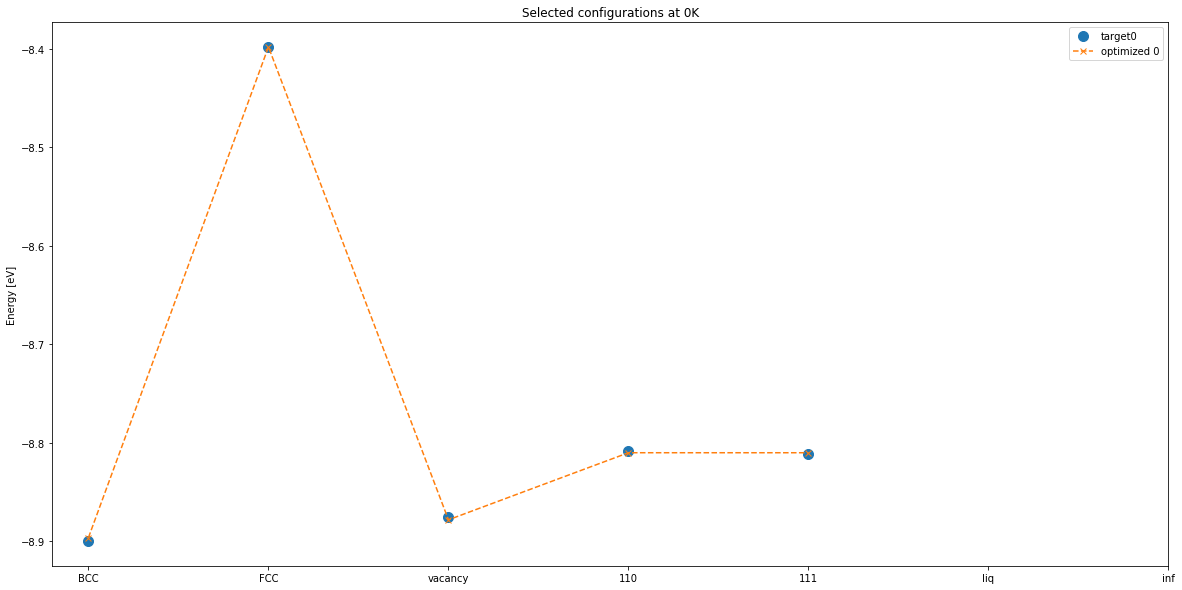

In [35]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['relax']['xyz']])[:-2]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [6])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-2][:-2])
        print('Model:', opti_out[-2][:-2])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-2][:-2]))/nat)
        plt.plot(np.array(targ_out[-2][:-2])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(np.array([o for o in opti_out[-2][:-2]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

13
Targ: [-271.8047221070888, -837.1711089986524, -1079.5267350307165, -1139.2, -1100.8887858645915, -1014.6561261471663, -909.2807161131147, -800.6633444635341, -697.0611202328876, -602.3043063713144, -517.7429994565125, -443.4032853774631, -378.657941519064]
Model: [-268.01653182308155, -825.6909491763752, -1070.8429256792974, -1138.7488477377608, -1091.6473294287673, -1005.4501862742802, -902.2479595240828, -791.9733141355346, -687.6603625120888, -600.222799832683, -521.4371681836519, -439.42695875639924, -362.9073642311022]
[0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625
 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625 0.1015625]
0 0.00010828214477099634


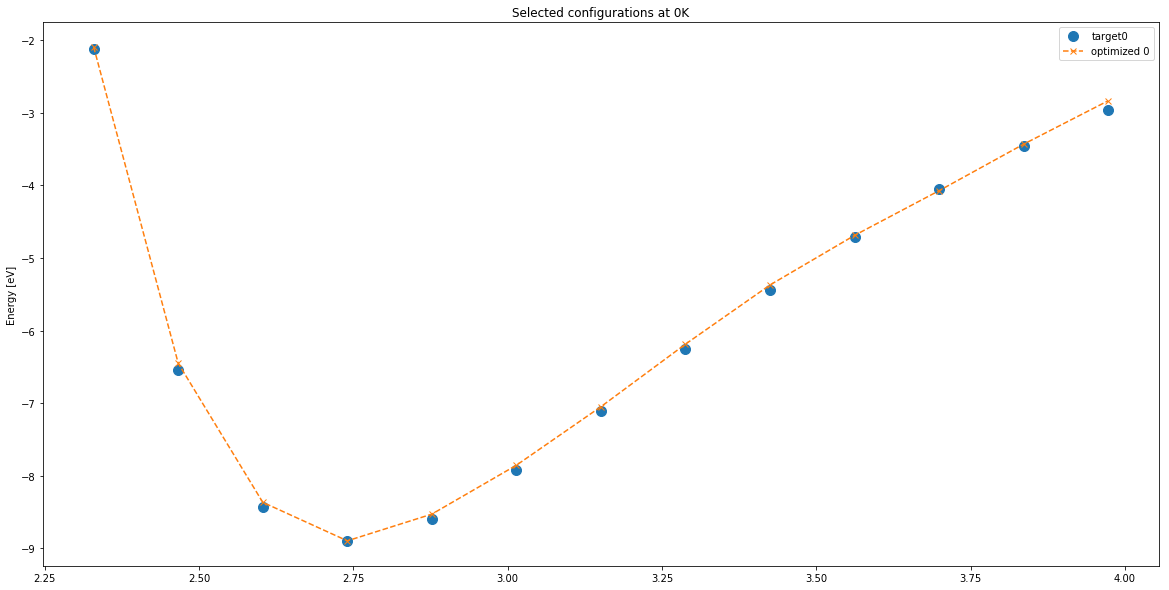

In [36]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['eos']['xyz']])[1:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM, [6])
    plt.title('Selected configurations at 0K')
    if i == 0:
        print('Targ:', targ_out[-1][1:])
        print('Model:', opti_out[-1][1:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[-1][1:]))/nat)
        plt.plot(reos, np.array(targ_out[-1][1:])/nat, 'o', label='target'+str(i), markersize=10)
        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

        
    #print('Opti:', [o for o in opti_out[-1][:-1]])
    plt.plot(reos, np.array([o for o in opti_out[-1][1:]])/nat, 'x--', label='optimized '+str(i))
#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.7533)
#plt.ylim(-8.9, -8.35)
#plt.xlim(0, 4)

plt.legend()

1138
[8.890625 8.890625 8.890625 ... 8.890625 8.890625 8.890625]
0 0.00010828214477099634


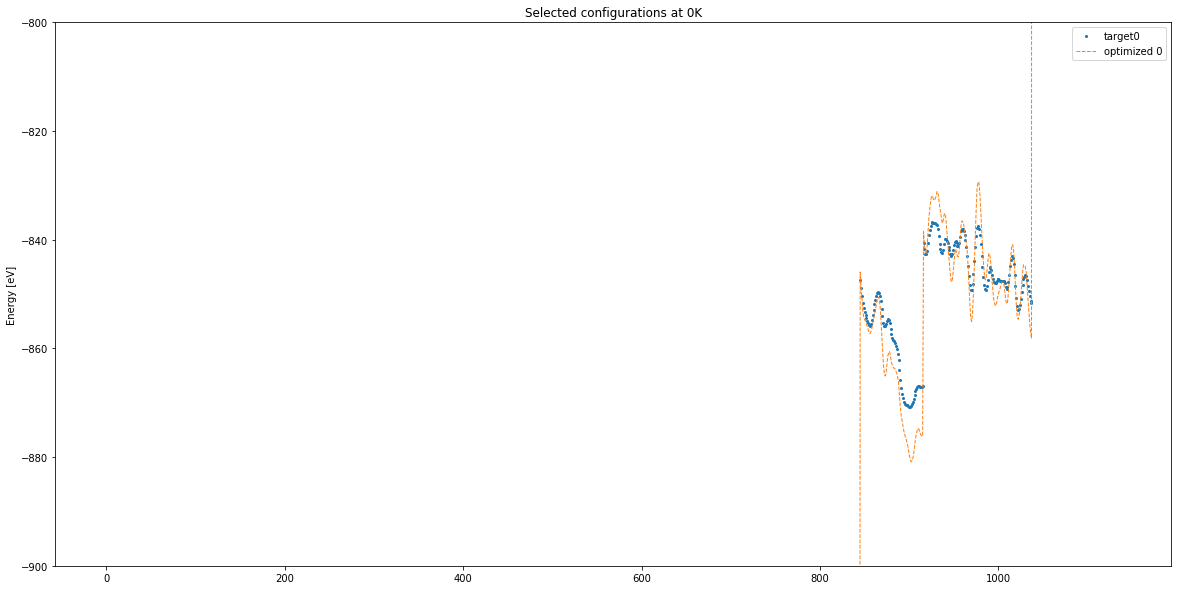

In [65]:
plt.figure(figsize=(20,10))

nat = np.array([len(x) for x in targ_ready['md']['xyz']])[:]
print(len(nat))

for i, params_uopt in enumerate(optimal_parameters):

    #print(params_uopt[1])

    opti_out, targ_out = udif_print(params_uopt[1], stats, target, utot_EAM,[6])
    plt.title('Selected configurations at 0K')
    if i == 0:
        #print('Targ:', targ_out[0][:])
        #print('Model:', opti_out[0][:])

        #nat = np.array([len(x) for x in targ_dict['relax']['xyz']])
        print(len(np.array(targ_out[0][:]))/nat)
        #plt.plot(np.array(targ_out[0][:])/nat, 'o', label='target'+str(i), markersize=10)
        plt.plot(np.array(targ_out[0][:]), 'o', label='target'+str(i), markersize=2)

        
    if params_uopt[0] > 0.6e-3:
        continue
    #if i != 10 and i != 12:
    #    continue
    print(i, params_uopt[0])

    #print('Opti:', [o for o in opti_out[-1][:-1]])
    #plt.plot(np.array([o for o in opti_out[0][:]])/nat, 'x--', label='optimized '+str(i))
    plt.plot(np.array([o for o in opti_out[0][:]]), '--', label='optimized '+str(i), lw=1.0)

#    else:
#        plt.plot([o for o in opti_out[-1][:-1]], 'x--', label='optimized '+str(i))
#        plt.plot(targ_out[-1][:-1], 'o', markersize=10)

#plt.xticks([0, 1, 2, 3, 4, 5, 6], ['BCC','FCC', 'vacancy','110','111','liq','inf'])
plt.ylabel('Energy [eV]')
#plt.ylim(-1145, -1136)
#plt.ylim(-8.905, -8.533)
#plt.ylim(-8.9, -8.35)

plt.ylim(-1180,-700)
#plt.ylim(-1136,-1132)
plt.ylim(-900,-800)

plt.legend()

In [42]:
for i, params_uopt in enumerate(optimal_parameters):
    if params_uopt[0] > 1.1e-3:
        continue
    print(i, params_uopt[0], '\n', params_uopt[1])

0 0.00010828214477099634 
 [-0.507273001, 0.000100986691, 23.0585042, -0.41707247, -0.389422601, 3.49772322, -3.98924634, 1.64695646, -0.152760962, -0.0593811135]


In [43]:
stats_opt['hyperparams']

NameError: name 'stats_opt' is not defined

In [44]:
stats_opts[it]['hyperparams']

[2.65, 3.0, 3.5, 4.0, 4.356, 4.75, 5.25, 5.75]

In [45]:
pars_out = {}
pars_out['pair_nodes'] = stats_opts[it]['hyperparams']
pars_out['mb_node'] = 6
pars_out['params'] = [optimal_parameters[0]]

In [46]:
optimal_list = []

#with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
#    optimal_list = pickle.load(fi)

#if type(optimal_list) != list:
#    optimal_list = [optimal_list]

optimal_list.append(pars_out)

with open(os.path.join(working, 'pars_out.pickle'), 'wb') as fo:
    pickle.dump(optimal_list, fo)

In [47]:
with open(os.path.join(working, 'pars_out.pickle'), 'rb') as fi:
    optimal_list = pickle.load(fi)

In [48]:
optimal_list

[{'pair_nodes': [2.65, 3.0, 3.5, 4.0, 4.356, 4.75, 5.25, 5.75],
  'mb_node': 6,
  'params': [(0.00010828214477099634,
    [-0.507273001,
     0.000100986691,
     23.0585042,
     -0.41707247,
     -0.389422601,
     3.49772322,
     -3.98924634,
     1.64695646,
     -0.152760962,
     -0.0593811135])]}]

In [49]:
# Total pair potential
pos = targ_ready['relax']['xyz'][0]
bx = targ_ready['relax']['box'][0]
rr, rx = pair_dist_cutoff(pos, bx, 5.5)

In [50]:
# embedding function
F = lambda d, a: a[0]*d**0.5 + a[1]*d + a[2]*d**2

V = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

# Cohesive potential (cubic splines - same form as V)
phi = lambda r, aa, cc: sum([a*(rc - r)**3 for a, rc in zip(aa, cc) if r < rc])

rho = lambda r, aa, kk: sum([a*(rk - r)**3 for a, rk in zip(aa, kk) if r < rk and r > 0.01])

In [51]:
optimal_list[-1]['params'][0][1]

[-0.507273001,
 0.000100986691,
 23.0585042,
 -0.41707247,
 -0.389422601,
 3.49772322,
 -3.98924634,
 1.64695646,
 -0.152760962,
 -0.0593811135]

In [52]:
#optimal_parameters.append(tuple([output[1:], params_uopt]))
pair_y = optimal_list[-1]['params'][0][1][2:]
par = optimal_list[-1]['params'][0][1][:2]
many_y = [par[0], 0.0, par[1]]
V_x_r = optimal_list[-1]['pair_nodes'] #stats_opt['hyperparams']
rho_x_r = [V_x_r[optimal_list[-1]['mb_node']]] #stats_opt['hyperparams'][4:5]
rho_x_a = [1.0]

In [53]:
pair_y, many_y, V_x_r, rho_x_r

([23.0585042,
  -0.41707247,
  -0.389422601,
  3.49772322,
  -3.98924634,
  1.64695646,
  -0.152760962,
  -0.0593811135],
 [-0.507273001, 0.0, 0.000100986691],
 [2.65, 3.0, 3.5, 4.0, 4.356, 4.75, 5.25, 5.75],
 [5.25])

In [54]:
ene = []
for a in np.linspace(0.5, 2.0, 101):
    z = a*rr
    u_pair = 0.5*np.sum([V(x, pair_y, V_x_r) for x in z.flatten() if x > 0.1])

    u_many = 0.0
    for i in range(z.shape[0]):
        d = np.sum([phi(x, rho_x_a, rho_x_r) for x in z[i] if x > 0.1])
        u_many += F(d, many_y)

    ene.append([a, u_pair, u_many, u_pair+u_many])

ene = np.array(ene)

Text(0,0.5,'U')

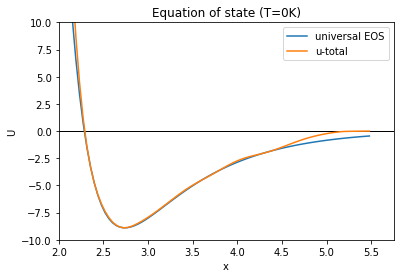

In [55]:
#plt.plot(ene[:,0], ene[:,1]/54, label='pair')
#plt.plot(ene[:,0], ene[:,2]/54, label='manybody')
plt.title('Equation of state (T=0K)')
plt.plot(ene[:,0]*2.74, [universal_eos(x, 'W') for x in ene[:,0]], label='universal EOS')
plt.plot(ene[:,0]*2.74, ene[:,3]/128, label='u-total')
plt.hlines(0.0,0.5,6.0,lw=1)
plt.legend()
plt.xlim(2.0, 5.75)
plt.ylim(-10,10)

plt.xlabel('x')
plt.ylabel(r'U')

In [56]:
pair_a = optimal_list[-1]['params'][0][1][2:]#pars_in1[2:]
pair_r = optimal_list[-1]['pair_nodes']

rho_a = [1.0]
rho_r = [pair_r[optimal_list[-1]['mb_node']]]

par = optimal_list[-1]['params'][0][1][:2]
many_a = [par[0], 0.0, par[1]]

In [58]:
# Ranges of densities and separations

nr = 5000
rcut = pair_r[-1]
dr = rcut/nr

rhomax = 12.0*phi(1.5, rho_a, rho_r)
print('rhomax:', rhomax)
rhomax = 1000.0
nrho = 5000
drho = rhomax/nrho

ri = 1.0
ro = 2.0

# W properties
na = 74
ma = 183.84
lc = 3.1653
alat = 'bcc'

# System composition
n_el = 1
el_name = ['W']

rhomax: 632.8125


In [59]:
def u_trans(r, unucl, ueq, ri=1.0, ro=2.0):
    """Transition between the core and equillibrium potentials"""
    if r < ri:
        return unucl
    elif r < ro:
        x = (ro + ri - 2*r)/(ro - ri)
        eta = 3/16*x**5 - 5/8*x**3 + 15/16*x + 1/2
        return ueq + eta*(unucl - ueq)
    else:
        return ueq

In [60]:

# prepare lists of values
dens = np.linspace(0., rhomax-drho, nrho, endpoint=True)
r = np.linspace(0., rcut-dr, nr, endpoint=True)
r2 = np.linspace(0., rcut, 201)

fembd = [F(d, many_a) for d in dens] # W
edens = np.array([phi(x, rho_a, rho_r) for x in r])

# 1. Cubic spline for r > r_o
f_outer = [V(x, pair_a, pair_r) for i, x in enumerate(r)]
# 2. Repulsive core for r < r_i (precalculate up to r_o)
f_inner = [0.0] + [u_core(x) for x in r[1:]]
# 3. Transition region for r_i < r < r_o
fpair = [x*u_trans(x, f_inner[i], f_outer[i]) for i, x in enumerate(r)]
#fpair = f_outer

In [61]:
# LAMMPS format
pot_path = '../sim/potentials'

with open(os.path.join(pot_path, 'W_lv_2.eam.fs'), 'w') as fo:
    
    # Comment section
    fo.write('Comment 1\n')
    fo.write('Comment 2\n')
    fo.write('Comment 3\n')
    
    # Number of elements
    fo.write(f"{n_el:5d} ")
    for i in range(n_el):
        fo.write(f"{el_name[i]:2}")
    fo.write("\n")
    
    # number of grid points, step size, and cutoff
    fo.write(f"{nrho:5d}{drho:24.16e}{nr:5d}{dr:24.16e}{rcut:24.16e}\n")
    
    # atomic number, mass, lattice size, lattice type
    fo.write(f"{na:5d} {ma:14.4f} {lc:14.4f} {alat:10}\n")
    
    # Embeding function
    for i in range(nrho//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fembd[i*4:i*4+4]))
    
    # Electronic density
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*edens[i*4:i*4+4]))
        
    # Pair potential
    for i in range(nr//4):
        fo.write("{0:20.12e}{1:20.12e}{2:20.12e}{3:20.12e}\n".format(*fpair[i*4:i*4+4]))